## 4.2 Transformer Model Architecture

The Transformer architecture, introduced in *"Attention is All You Need"* (Vaswani et al., 2017), revolutionized NLP by eliminating recurrence and enabling parallel training. It relies entirely on **attention mechanisms** to draw global dependencies between input and output.

### 🔹 Core Components


### 1. Positional Encoding

Transformers do **not** process tokens sequentially, so positional information must be explicitly added.

**Mathematical Definition**:

For each position $pos$ and dimension $i$ in the embedding:
- $PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}} \right)$  
- $PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}} \right)$

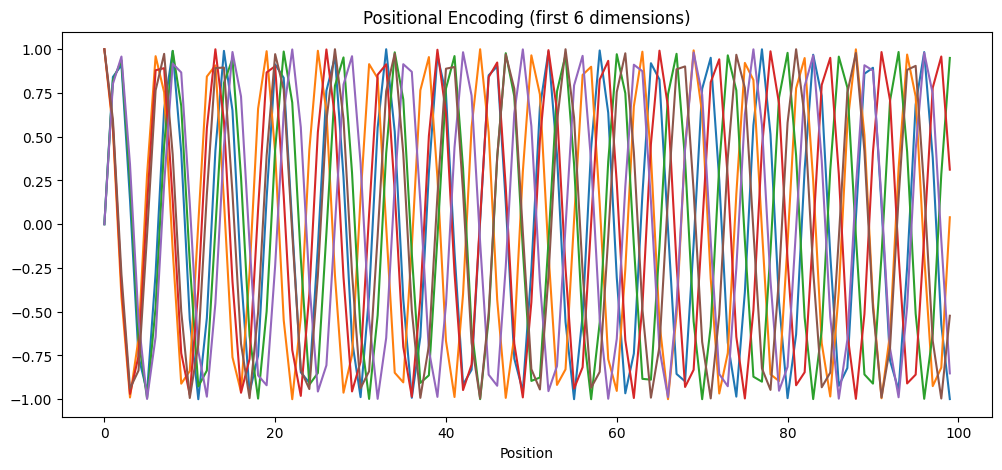

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

pe = positional_encoding(100, 512)
plt.figure(figsize=(12, 5))
plt.plot(pe[:, :6])
plt.title("Positional Encoding (first 6 dimensions)")
plt.xlabel("Position")
plt.show()

### 2. Scaled Dot-Product Attention

**Equation**:

Given queries $Q$, keys $K$, and values $V$:

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$

In [2]:
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    weights = torch.nn.functional.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output

### 3. Multi-Head Attention

Instead of a single attention function, we run multiple in parallel:
- Project input $X$ into $h$ sets of $Q_i, K_i, V_i$
- Apply attention in parallel
- Concatenate and project outputs

In [3]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(B, T, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]
        attn = scaled_dot_product_attention(Q, K, V)
        attn = attn.permute(0, 2, 1, 3).reshape(B, T, C)
        return self.out_proj(attn)

### 4. Transformer Block

Each **Transformer block** contains:
- Multi-head self-attention
- Layer norm and residuals
- Feed-forward network (FFN)

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

### 5. Encoder & Decoder Structure
- **Encoder**: stack of $N$ identical layers  
  - Input embeddings + positional encoding  
  - Each layer: self-attention + FFN
- **Decoder**: similar, but includes masked self-attention and encoder-decoder attention.

### 🔹 Applications in NLP

Transformers power **modern NLP models**:
- **BERT**: bi-directional encoder (masked language modeling)
- **GPT**: decoder-only, autoregressive generation
- **T5, BART**: encoder-decoder architecture

These models fine-tune the Transformer for tasks like:
- Translation
- Text classification
- Question answering
- Summarization

### ✅ Summary Table

| Component            | Role                                                 |
|---------------------|------------------------------------------------------|
| Positional Encoding | Inject order into embeddings                        |
| Self-Attention       | Relate each token to all others                    |
| Multi-Head Attention | Capture multiple perspectives (heads)              |
| Layer Norm + FFN     | Stabilize and enrich token representations         |
| Encoder              | Input understanding (e.g., BERT)                   |
| Decoder              | Output generation (e.g., GPT, T5)                  |